Reading the dataset of ignitions started with Electric line.

In [1]:
import numpy as np
import pandas as pd
import random
import itertools
from scipy.optimize import minimize

In [2]:
df = pd.read_csv("Dataset/Dataset.csv", encoding = 'latin1')

In [4]:
new_df = df.drop(['OBJECTID1','File_tag','Provider','Date','Address_of_incident_4','CODE','NAME','ID_of__nearest__asset_5',
             'ID_of_nearest__polyphase__line_','Type_of_primary_asset__involved','Kind_of_fire_start_as_per_Claus',
             'Location__area_12','Fire__danger__rating_13','DNSP_record_number_14','OSIRIS___ESV__reference__number',
             'Fault__description_16','Overhead_conductors','BUFF_DIST','FOR_CODE','STATION_ID','CODE','NAME','WeatherStation',
             'Voltage_of_line_in_which__fire_','Network_categorisation_8','Phase_s__of__line_or__transform','FOR_TYPE','FOR_CAT'], axis = 1)

In [5]:
real_data_df = new_df.dropna()


In [6]:
real_data_df.head(3)

,DateOnly,Date_1,Time_2,Latitude_3,Longitude_3,Location_multiplier,Danger_multiplier,Product_of_multipliers,COVER,HEIGHT,FOREST,Elevation,Monthly Avg Rainfall,Monthly Mean Max Temperature,Monthly Mean Solar Exposure
1,24/01/2020,43854.00000,0.667361,-38.754127,143.667405,0.2,0.5,0.1,6,6,0,7.690627,129.4,26.9,21.8
3,20/02/2018,43151.69375,43151.693750,-38.669141,145.615890,0.2,1.0,0.2,6,6,0,25.977764,1.2,27,20.8
4,23/02/2018,43154.91458,43154.914580,-38.703816,145.819190,4.6,0.5,2.3,6,6,0,9.772949,1.2,27,20.8


In [7]:

real_data_df.shape

(1625, 15)

In [8]:
#Randomly select 50 records from the dataset

random.seed(10)
total_records = len(real_data_df.index)
random.seed(10)
imag_data_df = real_data_df.sample(n=total_records,replace=True)
imag_data_df.shape

(1625, 15)

In [9]:
imag_data_df.head(2)

,DateOnly,Date_1,Time_2,Latitude_3,Longitude_3,Location_multiplier,Danger_multiplier,Product_of_multipliers,COVER,HEIGHT,FOREST,Elevation,Monthly Avg Rainfall,Monthly Mean Max Temperature,Monthly Mean Solar Exposure
1036,18/02/2019,43514.52778,43514.527780,-37.885382,145.411886,19.8,0.5,9.90,2,2,1,233.032562,20.3,26,21.4
621,9/12/2016,42713.00000,0.372222,-37.958099,145.144480,0.2,0.2,0.04,6,6,0,40.999207,47.7,25.5,24


## F-factor 
F-factor weight allocation: ground-fire (1.0) or other (0.2)

f.ground.w=1.0
f.other.w=1.0

## G-factor 
G-factor weight allocation: LBRA (0.25), HBRA (1.0), REFCL (1.5), PRF (4.5)  
Location Multiplier

g.lbra.w=0.2
g.hbra.w=1.0
g.refcl.w=4.6,
g.prf.w=19.8

## T-factor 
T-factor weight allocation: No forecast (0.1), Low-Moderate (0.2), high (0.5), very high (1.0), severe (2.0), extreme (3.0), code red (5.0)

Danger Multiplier

t.noforecast.w=0.1
t.low2mod.w=0.2
t.high.w=0.5
t.veryhigh.w=1.0
t.severe.w=2.0
t.extreme.w=3.5
t.codered.w=5


In [10]:
# Create a Factor/case Matrix  we have 4 G-Factor and 7 T-factor so a total of 28 cases.

g_factors = [0.2,1.0,4.6,19.8]
t_factors = [0.1,0.2,0.5,1,2.0,3.5,5]
cases = [g_factors,t_factors]
cases_list = list(itertools.product(*cases))
len(cases_list)
#cases_list

28

In [11]:
# data frame for cases real 

df_cases_real = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_real)))
df_cases_real.insert((len(df_cases_real.columns)-1)+1 , 'count', 0)
df_cases_real.head(5)

,g_factors,t_factors,case,count
0,0.2,0.1,1,0
1,0.2,0.2,2,0
2,0.2,0.5,3,0
3,0.2,1.0,4,0
4,0.2,2.0,5,0


In [12]:
# data frame for cases imag 

df_cases_imag = pd.DataFrame(cases_list, columns=['g_factors', 't_factors'])
df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_imag)))
df_cases_imag.insert((len(df_cases_imag.columns)-1)+1 , 'count', 0)
df_cases_imag.head(5)

,g_factors,t_factors,case,count
0,0.2,0.1,1,0
1,0.2,0.2,2,0
2,0.2,0.5,3,0
3,0.2,1.0,4,0
4,0.2,2.0,5,0


In [13]:
# classify records according to case type Real 

group_rows_real = pd.DataFrame(real_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))
group_rows_real.head(5)

,Location_multiplier,Danger_multiplier,count
0,0.2,0.1,238
1,0.2,0.2,234
2,0.2,0.5,262
3,0.2,1.0,122
4,0.2,2.0,39


In [14]:
# classify records according to case type Imag

group_rows_imag = pd.DataFrame(imag_data_df.groupby(['Location_multiplier','Danger_multiplier']).size().reset_index(name='count'))
group_rows_imag.head(5)


,Location_multiplier,Danger_multiplier,count
0,0.2,0.1,226
1,0.2,0.2,265
2,0.2,0.5,260
3,0.2,1.0,128
4,0.2,2.0,44


Group by different factors of T-Factors and G-Factors

# Impact factor Real 

## Impact factor  (Cases*Number of Records) => $C_{i}*N$
where C is the case number

So, the *IRU* is calculated as  $\sum_{i=1}^{n} C_{i}*N$

In [15]:
# adding grouped rows to Real cases data frame
for index_cases, row_cases in df_cases_real.iterrows():
    for index_records, row_records in group_rows_real.iterrows():
        if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
            df_cases_real.loc[index_cases, 'count'] =   row_records['count'] 

# Calculate impact factor for Real Data frame  
# Imapact factor  (Cases*NumberofRecords) => C*N 

df_cases_real["IRU_real"] = df_cases_real["g_factors"] * df_cases_real["t_factors"] * df_cases_real["count"]  

df_cases_real

,g_factors,t_factors,case,count,IRU_real
0,0.2,0.1,1,238.0,4.76
1,0.2,0.2,2,234.0,9.36
2,0.2,0.5,3,262.0,26.20
3,0.2,1.0,4,122.0,24.40
4,0.2,2.0,5,39.0,15.60
5,0.2,3.5,6,16.0,11.20
6,0.2,5.0,7,0.0,0.00
7,1.0,0.1,8,78.0,7.80
8,1.0,0.2,9,86.0,17.20
9,1.0,0.5,10,106.0,53.00


# Impact factor Imaginary 

## Impact factor  (Cases*Number of Records) => $C_{i}*N$
where C is the case number

So, the *IRU* is calculated as  $\sum_{i=1}^{n} C_{i}*N$

In [16]:
# adding grouped rows to Imag cases data frame
for index_cases, row_cases in df_cases_imag.iterrows():
    for index_records, row_records in group_rows_imag.iterrows():
        if (row_cases['g_factors'] == row_records['Location_multiplier'] and  row_cases['t_factors'] == row_records['Danger_multiplier']):
            df_cases_imag.loc[index_cases, 'count'] =   row_records['count'] 


# Calculate impact factor for Imag Data frame  

df_cases_imag["IRU_imag"] = df_cases_imag["g_factors"] * df_cases_imag["t_factors"] * df_cases_imag["count"] 

df_cases_imag


,g_factors,t_factors,case,count,IRU_imag
0,0.2,0.1,1,226.0,4.52
1,0.2,0.2,2,265.0,10.60
2,0.2,0.5,3,260.0,26.00
3,0.2,1.0,4,128.0,25.60
4,0.2,2.0,5,44.0,17.60
5,0.2,3.5,6,19.0,13.30
6,0.2,5.0,7,0.0,0.00
7,1.0,0.1,8,65.0,6.50
8,1.0,0.2,9,71.0,14.20
9,1.0,0.5,10,107.0,53.50


In [18]:
# Define where Cases Real and Cases Imag 
 
c_real = np.zeros(shape=[28,]) # cases Real
c_imag = np.zeros(shape=[28,]) # cases Imag
c0 = np.zeros(shape=[28,1])
c_real = df_cases_real[df_cases_real.columns[4]].to_numpy()
c_imag = df_cases_imag[df_cases_imag.columns[4]].to_numpy()

c0 = np.subtract(c_real,c_imag)   # 30,000 times 
c0


array([  0.24,  -1.24,   0.2 ,  -1.2 ,  -2.  ,  -2.1 ,   0.  ,   1.3 ,
         3.  ,  -0.5 ,   4.  ,  -6.  ,   0.  ,   0.  ,  -1.38, -12.88,
       -13.8 ,  82.8 ,   0.  ,   0.  ,   0.  ,   0.  ,  19.8 ,   9.9 ,
        19.8 ,   0.  ,  69.3 ,   0.  ])

## Optimization and root finding (scipy.optimize)

SciPy optimize provides functions for minimizing (or maximizing) objective functions, possibly subject to constraints. It includes solvers for nonlinear problems (with support for both local and global optimization algorithms), linear programing, constrained and nonlinear least-squares, root finding, and curve fitting.

In [19]:
# Optimization Functions

# Objective
x_penalty = 25000

# get n_real and n_imag

n_real = df_cases_real["count"] 
n_imag = df_cases_imag["count"] 

c0 = np.random.randn(28) 


def objective(c0):
    i = 0
    iru_real = 0
    iru_imag = 0
    for i in range(27):
      # calculate Iru_real
      prod_real = c0[i] * n_real[i]
      iru_real = iru_real + prod_real
      #calculate Iru_imag
      prod_imag = c0[i] * n_imag[i] 
      iru_imag = iru_imag + prod_imag
    return (iru_real - iru_imag)




In [20]:
# Contraints 

def constraint1(c0):
    return c0[1] - c0[0]     # c2 - c1 >= 0

def constraint2(c0):
    return c0[2] - c0[1]     # c3 - c2 >= 0 

def constraint3(c0):
    return c0[3] - c0[2]     # c4 - c3 >= 0 

def constraint4(c0):
    return c0[4] - c0[3]     # c5 - c4 >= 0

def constraint5(c0):
    return c0[5] - c0[4]     # c6 - c5 >= 0

def constraint6(c0):
    return c0[6] - c0[5]     # c7 - c6 >= 0

def constraint7(c0):
    return c0[7] - c0[6]     # c8 - c1 >= 0  cant be because of row.

def constraint8(c0):
    return c0[8] - c0[7]     # c9 - c8 >= 0

def constraint9(c0):
    return c0[9] - c0[8]     # c10 - c9 >= 0

def constraint10(c0):
    return c0[10] - c0[9]    # c11 - c10 >= 0

def constraint11(c0):
    return c0[11] - c0[10]   # c12 - c11 >= 0

def constraint12(c0):
    return c0[12] - c0[11]   # c13 - c12 >= 0

def constraint13(c0):
    return c0[13] - c0[12]   # c14 - c1 >= 0  cant be because of row 

def constraint14(c0):
    return c0[14] - c0[13]   # c15 - c14 >= 0

def constraint15(c0):
    return c0[15] - c0[14]   # c16 - c15 >= 0

def constraint16(c0):
    return c0[16] - c0[15]   # c17 - c16 >= 0

def constraint17(c0):
    return c0[17] - c0[16]   # c18 - c17 >= 0

def constraint18(c0):
    return c0[18] - c0[17]   # c19 - c18 >= 0

def constraint19(c0):
    return c0[19] - c0[18]   # c20 - c19 >= 0

def constraint20(c0):
    return c0[20] - c0[19]   # c21 - c20 >= 0

def constraint21(c0):
    return c0[21] - c0[20]   # c21 - c7 >= 0

def constraint22(c0):
    return c0[22] - c0[21]   # c23 - c22 >= 0

def constraint23(c0):
    return c0[23] - c0[22]   # c24 - c23 >= 0

def constraint24(c0):
    return c0[24] - c0[23]   # c25 - c24 >= 0

def constraint25(c0):
    return c0[25] - c0[24]   # c26 - c25 >= 0

def constraint26(c0):
    return c0[26] - c0[25]   # c27 - c26 >= 0

def constraint27(c0):
    return c0[27] - c0[26]   # c28 - c27 >= 0

def constraint28(c0):
    i = 0
    iru_real = 0
    iru_imag = 0
    for i in range(27):
      # calculate Iru_real
      prod_real = c0[i] * n_real[i]
      iru_real = iru_real + prod_real
      #calculate Iru_imag
      prod_imag = c0[i] * n_imag[i] 
      iru_imag = iru_imag + prod_imag
    return ((iru_real - iru_imag) * 25000) - 1000000
   


con1 = {'type': 'ineq', 'fun': constraint1}
con2 = {'type': 'ineq', 'fun': constraint2}
con3 = {'type': 'ineq', 'fun': constraint3}
con4 = {'type': 'ineq', 'fun': constraint4}
con5 = {'type': 'ineq', 'fun': constraint5}
con6 = {'type': 'ineq', 'fun': constraint6}
con7 = {'type': 'ineq', 'fun': constraint7}
con8 = {'type': 'ineq', 'fun': constraint8}
con9 = {'type': 'ineq', 'fun': constraint9}
con10 = {'type': 'ineq', 'fun': constraint10}
con11 = {'type': 'ineq', 'fun': constraint11}
con12 = {'type': 'ineq', 'fun': constraint12}
con13 = {'type': 'ineq', 'fun': constraint13}
con14 = {'type': 'ineq', 'fun': constraint14}
con15 = {'type': 'ineq', 'fun': constraint15}
con16 = {'type': 'ineq', 'fun': constraint16}
con17 = {'type': 'ineq', 'fun': constraint17}
con18 = {'type': 'ineq', 'fun': constraint18}
con19 = {'type': 'ineq', 'fun': constraint19}
con20 = {'type': 'ineq', 'fun': constraint20}
con21 = {'type': 'ineq', 'fun': constraint21}
con22 = {'type': 'ineq', 'fun': constraint22}
con23 = {'type': 'ineq', 'fun': constraint23}
con24 = {'type': 'ineq', 'fun': constraint24}
con25 = {'type': 'ineq', 'fun': constraint25}
con26 = {'type': 'ineq', 'fun': constraint26}
con27 = {'type': 'ineq', 'fun': constraint27}
con28 = {'type': 'ineq', 'fun': constraint28}



In [21]:
#optimize

cons = ([con1,con2,con3,con4,con5,con6,con7,con8,con9,con10,con11,con12,con13,con14,con15,con16,con17,con18,con19,con20,con21,con22,con23,con24,con25,con26,con27,con28])

# optimize
b = (1.0,100000.0)
bnds = (b,b, b, b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b,b)
solution = minimize(objective,c0,method='SLSQP',constraints=cons)
x = solution.x

# show final objective
print('Final Objective: ' + str(objective(x)))

# print solution
print('Solution')
print('c0 = ' + str(x[0]))
print('c1 = ' + str(x[1]))
print('c2 = ' + str(x[2]))
print('c3 = ' + str(x[3]))
print('c4 = ' + str(x[4]))
print('c5 = ' + str(x[5]))
print('c6 = ' + str(x[6]))
print('c7 = ' + str(x[7]))
print('c8 = ' + str(x[8]))
print('c9 = ' + str(x[9]))
print('c10 = ' + str(x[10]))
print('c11 = ' + str(x[11]))
print('c12 = ' + str(x[12]))
print('c13 = ' + str(x[13]))
print('c14 = ' + str(x[14]))
print('c15 = ' + str(x[15]))
print('c16 = ' + str(x[16]))
print('c17 = ' + str(x[17]))
print('c18 = ' + str(x[18]))
print('c19 = ' + str(x[19]))
print('c20 = ' + str(x[20]))
print('c21 = ' + str(x[21]))
print('c22 = ' + str(x[22]))
print('c23 = ' + str(x[23]))
print('c24 = ' + str(x[24]))
print('c25 = ' + str(x[25]))
print('c26 = ' + str(x[26]))
print('c27 = ' + str(x[27]))

# dataframe with values of Cases


Final Objective: 40.00000000001205
Solution
c0 = -1.1952710722587148
c1 = -1.1952710722590014
c2 = -0.5681670843727067
c3 = -0.5681670843727632
c4 = -0.5681670843727569
c5 = -0.23672144255771516
c6 = 0.15683122926656162
c7 = 0.15683122926665316
c8 = 0.1568312292666661
c9 = 0.15683122926653936
c10 = 0.15683122926657078
c11 = 0.15683122926653043
c12 = 0.1568312292665471
c13 = 0.15683122926654364
c14 = 0.1568312292665242
c15 = 0.15683122926647453
c16 = 0.1568312292665307
c17 = 0.4108471305278121
c18 = 0.41084713052768446
c19 = 0.4108471305276879
c20 = 0.4108471305276877
c21 = 0.410847130527696
c22 = 0.4108471305277108
c23 = 0.4108471305276946
c24 = 0.4108471305276894
c25 = 0.41084713052768446
c26 = 0.41084713052769006
c27 = 0.4108471305276809


In [22]:
df_cases_values = pd.DataFrame(x, columns=['values'])
df_cases_values.insert((len(df_cases_values.columns)-1)+1 , 'case', range(1, 1 + len(df_cases_values)))
df_cases_values

,values,case
0,-1.195271,1
1,-1.195271,2
2,-0.568167,3
3,-0.568167,4
4,-0.568167,5
5,-0.236721,6
6,0.156831,7
7,0.156831,8
8,0.156831,9
9,0.156831,10


In [23]:
test_real_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
test_real_df['count'] = df_cases_real['count']
test_real_df['c'] = df_cases_values['values']
test_real_df['IRU'] = test_real_df['count'] * test_real_df['c']
sum_iru_real = np.sum(test_real_df['IRU'])


test_imag_df = pd.DataFrame(columns=['count', 'c', 'IRU'])
test_imag_df['count'] = df_cases_imag['count']
test_imag_df['c'] = df_cases_values['values']
test_imag_df['IRU'] = test_imag_df['count'] * test_imag_df['c']
sum_iru_imag = np.sum(test_imag_df['IRU'])

(((sum_iru_real - sum_iru_imag)) * 25000)


1000000.0000003041

In [24]:
sum_iru_real

-670.9110780543242

In [25]:
sum_iru_imag

-710.9110780543364

# Calculating the IRU for every year 

$$

(\sum_{i=1}^{n} C_{i}*N)_{real} - (\sum_{i=1}^{n} C_{i}*N)_{imag} * X_{Penalty}

$$

In [26]:

np.abs(sum_iru_real - sum_iru_imag) * 25000

1000000.0000003041

In [27]:
test_real_df.head(20)

,count,c,IRU
0,238.0,-1.195271,-284.474515
1,234.0,-1.195271,-279.693431
2,262.0,-0.568167,-148.859776
3,122.0,-0.568167,-69.316384
4,39.0,-0.568167,-22.158516
5,16.0,-0.236721,-3.787543
6,0.0,0.156831,0.000000
7,78.0,0.156831,12.232836
8,86.0,0.156831,13.487486
9,106.0,0.156831,16.624110


In [28]:
# Code for finding The factors values
g_factors_names = ['g_lbra','g_hbra','g_refcl','g_prf']
t_factors_names = ['t_noforecast','t_low2mod','t_high','t_veryhigh','t_severe','t_extreme','t_codered']
cases_names = [g_factors_names,t_factors_names]
cases_list_names = list(itertools.product(*cases_names))
len(cases_list_names)
cases_list_names

[('g_lbra', 't_noforecast'),
 ('g_lbra', 't_low2mod'),
 ('g_lbra', 't_high'),
 ('g_lbra', 't_veryhigh'),
 ('g_lbra', 't_severe'),
 ('g_lbra', 't_extreme'),
 ('g_lbra', 't_codered'),
 ('g_hbra', 't_noforecast'),
 ('g_hbra', 't_low2mod'),
 ('g_hbra', 't_high'),
 ('g_hbra', 't_veryhigh'),
 ('g_hbra', 't_severe'),
 ('g_hbra', 't_extreme'),
 ('g_hbra', 't_codered'),
 ('g_refcl', 't_noforecast'),
 ('g_refcl', 't_low2mod'),
 ('g_refcl', 't_high'),
 ('g_refcl', 't_veryhigh'),
 ('g_refcl', 't_severe'),
 ('g_refcl', 't_extreme'),
 ('g_refcl', 't_codered'),
 ('g_prf', 't_noforecast'),
 ('g_prf', 't_low2mod'),
 ('g_prf', 't_high'),
 ('g_prf', 't_veryhigh'),
 ('g_prf', 't_severe'),
 ('g_prf', 't_extreme'),
 ('g_prf', 't_codered')]

In [29]:

zeroes = np.zeros(shape=[28,11]) 
df_case_matrix = pd.DataFrame(zeroes,columns=['g_lbra','g_hbra','g_refcl','g_prf','t_noforecast','t_low2mod','t_high','t_veryhigh','t_severe','t_extreme','t_codered'])

df_case_matrix

i = 0
for g_fac,t_fac in cases_list_names:
    #print(g_fac,t_fac)
    df_case_matrix.loc[[i],[g_fac,t_fac]] = 1
    i = i+1
            


In [30]:
df_case_matrix['case']= df_cases_values['case']
df_case_matrix['values']= df_cases_values['values']
df_case_matrix
df_matrix_max = df_case_matrix.nlargest(11,'values')
df_case_matrix = df_case_matrix.sort_values(by=['values'],ascending=False)
df_case_matrix
#df_matrix_max

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,0.410847
22,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23,0.410847
21,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.410847
23,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24,0.410847
26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27,0.410847
24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25,0.410847
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20,0.410847
20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,0.410847
25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26,0.410847
18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,0.410847


In [32]:
zero_columns = (df_matrix_max != 0).any(axis=0)
zero_columns
(zero_columns == False).any(axis=0)


True

In [33]:


# print (top_val_with_at_least_one_1(df_case_matrix, 11))

def get_desired_subset(top_rows):
    for i in range(len(df_case_matrix)):
        df_subset = df_case_matrix.loc[i:i+top_rows-1].reset_index(drop=True)
        if (df_subset>0).any().all():
            return df_subset

    print('No such subset found that satisfies all constraints.')
    return pd.DataFrame()

top_rows = 3
df_case_matrix = df_case_matrix[(df_case_matrix>0).any(axis=1)].sort_values('values', ascending=False).reset_index(drop=True)
if len(df)>= top_rows:
    desired_df = get_desired_subset(3)
else:
    print('No such subset found that satisfies all constraints.')

df_case_matrix


No such subset found that satisfies all constraints.


,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,0.410847
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23,0.410847
2,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.410847
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24,0.410847
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27,0.410847
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25,0.410847
6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20,0.410847
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,0.410847
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26,0.410847
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,0.410847


In [34]:
def top_val_with_at_least_one_1(df_case_matrix, N):
    df_case_matrix = df_case_matrix.sort_values('values', ascending=False, ignore_index=True, kind='mergesort')

    m = (df_case_matrix.iloc[:, :11]
           .astype(bool)
           .rolling(N)
           .apply(lambda x: x.any())
           .fillna(0)
           .astype(bool)
           .all(axis=1))
    
    if m.any():
        idx = m.idxmax()
        return df_case_matrix.loc[idx-N+1:idx]
    else:
        return pd.DataFrame()

df_top_val = top_val_with_at_least_one_1(df_case_matrix, 11)
print (top_val_with_at_least_one_1(df_case_matrix, 11))

    g_lbra  g_hbra  g_refcl  g_prf  ...  t_extreme  t_codered  case    values
7      0.0     0.0      1.0    0.0  ...        0.0        1.0    21  0.410847
8      0.0     0.0      0.0    1.0  ...        0.0        0.0    26  0.410847
9      0.0     0.0      1.0    0.0  ...        0.0        0.0    19  0.410847
10     0.0     0.0      0.0    1.0  ...        0.0        1.0    28  0.410847
11     0.0     1.0      0.0    0.0  ...        0.0        0.0     9  0.156831
12     0.0     1.0      0.0    0.0  ...        0.0        0.0     8  0.156831
13     0.0     1.0      0.0    0.0  ...        0.0        0.0    11  0.156831
14     1.0     0.0      0.0    0.0  ...        0.0        1.0     7  0.156831
15     0.0     1.0      0.0    0.0  ...        1.0        0.0    13  0.156831
16     0.0     1.0      0.0    0.0  ...        0.0        1.0    14  0.156831
17     0.0     1.0      0.0    0.0  ...        0.0        0.0    10  0.156831

[11 rows x 13 columns]


In [35]:

df_matrix_max

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
17,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,18,0.410847
22,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23,0.410847
21,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22,0.410847
23,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,24,0.410847
26,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,27,0.410847
24,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25,0.410847
19,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20,0.410847
20,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,0.410847
18,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,0.410847
25,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26,0.410847


In [36]:
max_ones_df = pd.DataFrame((df_matrix_max == 1).sum(axis=0))
col_name_max_ones  =  (max_ones_df[0].idxmax())

df_matrix_max= df_matrix_max.sort_values(by=[col_name_max_ones],ascending=False)
df_matrix_max
max_ones_df

,0
g_lbra,0
g_hbra,0
g_refcl,4
g_prf,7
t_noforecast,1
t_low2mod,1
t_high,1
t_veryhigh,2
t_severe,2
t_extreme,2


In [37]:
numpy_array = df_matrix_max.to_numpy()
A = numpy_array[:,0:11]
A


array([[0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [38]:
b =  numpy_array[:, 12]
b

array([0.41084713, 0.41084713, 0.41084713, 0.41084713, 0.41084713,
       0.41084713, 0.41084713, 0.41084713, 0.41084713, 0.41084713,
       0.41084713])

In [39]:
z= np.linalg.lstsq(A,b)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [40]:
z

(array([0.        , 0.        , 0.31954777, 0.31954777, 0.09129936,
        0.09129936, 0.09129936, 0.09129936, 0.09129936, 0.09129936,
        0.09129936]),
 array([], dtype=float64),
 8,
 array([ 2.86058685e+00,  2.21889448e+00,  1.41421356e+00,  1.41421356e+00,
         1.41421356e+00,  1.00000000e+00,  1.00000000e+00,  9.45277807e-01,
         2.90563282e-16,  8.65981741e-17, -0.00000000e+00]))

In [41]:
# test non linear equations solve 

import scipy.optimize as opt
from numpy import exp

def f(variables) :
    (x,y) = variables
    first_eq = x + y**2 - 4
    second_eq = exp(x) + x*y - 3
    return [first_eq, second_eq]

solution = opt.fsolve(f, (0.1, 1)) # fsolve(equations, X_0)
print(solution)


[0.62034452 1.83838393]


In [42]:
 df_factors =  top_val_with_at_least_one_1(df_case_matrix, 11)
 df_factors

,g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered,case,values
7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21,0.410847
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26,0.410847
9,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,19,0.410847
10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,28,0.410847
11,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,9,0.156831
12,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8,0.156831
13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11,0.156831
14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7,0.156831
15,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,13,0.156831
16,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14,0.156831


In [43]:
#traver df_factors by rows 

eq_list = []

for index, row in df_factors.iterrows():
    eq=""
    if(row.g_lbra == 1):
      eq = " g_lbra *"
    if(row.g_hbra == 1):
      eq += " g_hbra *"
    if(row.g_refcl == 1):
      eq += " g_refcl *"
    if(row.g_prf == 1):
      eq += " g_prf *"
    if(row.t_noforecast == 1):
      eq += " t_noforecast *"
    if(row.t_low2mod == 1):
      eq += " t_low2mod *"
    if(row.t_high == 1):
      eq += " t_high *"
    if(row.t_veryhigh == 1):
      eq += " t_veryhigh *"
    if(row.t_severe == 1):
      eq += " t_severe *"
    if(row.t_extreme == 1):
      eq += " t_extreme *"
    if(row.t_codered == 1):
      eq += " t_codered*" 
    
    eq = eq[:-1]
    eq +=""
    if(row["values"] > 0):
      eq +=" - " + str(row['values'])
    if(row["values"] < 0):
      eq +=" + " + str(np.abs(row['values']))
    


    eq_list.append(eq) 


In [44]:
eq_list

[' g_refcl * t_codered - 0.4108471305276877',
 ' g_prf * t_severe  - 0.41084713052768446',
 ' g_refcl * t_severe  - 0.41084713052768446',
 ' g_prf * t_codered - 0.4108471305276809',
 ' g_hbra * t_low2mod  - 0.1568312292666661',
 ' g_hbra * t_noforecast  - 0.15683122926665316',
 ' g_hbra * t_veryhigh  - 0.15683122926657078',
 ' g_lbra * t_codered - 0.15683122926656162',
 ' g_hbra * t_extreme  - 0.1568312292665471',
 ' g_hbra * t_codered - 0.15683122926654364',
 ' g_hbra * t_high  - 0.15683122926653936']

In [45]:
# test non linear equations solve 


import scipy.optimize as opt
from math import exp 

def f(variables) :
    [g_lbra,g_hbra,g_refcl,g_prf,t_noforecast,t_low2mod,t_high,t_veryhigh,t_severe,t_extreme,t_codered] = variables
    res = []
    for eq in eq_list:
        res.append(eval(eq))
    return res

solution= opt.fsolve(f, [0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.1,0.01,0.0001],maxfev=100000)
#solution= opt.root(f, [0.1,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.1,0.01,0.0001])    
print(solution)

[1.e-01 1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 6.e-01 7.e-01 1.e-01 1.e-02
 1.e-04]


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [46]:

""" Try more starting-points fsolve """
N = 1000
factors_solutions = np.zeros(shape=[N,11])
x0 = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

for i in range(N):
    x0 = np.random.uniform(size=x0.shape)
    solution= opt.fsolve(f, x0)
    factors_solutions[i] = solution
    

# RSS if not accurate 

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


In [47]:

factors_solutions.shape


(1000, 11)

In [48]:
df_factors_solutions = pd.DataFrame(factors_solutions, columns=['g_lbra','g_hbra','g_refcl','g_prf','t_noforecast','t_low2mod','t_high','t_veryhigh','t_severe','t_extreme','t_codered'])

In [49]:
estimated_c_values = np.zeros(shape=[11,N])
i = 0
j = 0
for index, row_factors_sol in df_factors_solutions.iterrows():
  for index, row_factors_val in df_top_val.iterrows():
    g_fac = 0
    t_fac = 0 
    if(row_factors_val.g_lbra == 1):
      g_fac = row_factors_sol.g_lbra
    if(row_factors_val.g_hbra == 1):
      g_fac = row_factors_sol.g_hbra
    if(row_factors_val.g_refcl == 1):
      g_fac = row_factors_sol.g_refcl
    if(row_factors_val.g_prf == 1):
      g_fac = row_factors_sol.g_prf
    
    if(row_factors_val.t_noforecast == 1):
      t_fac = row_factors_sol.t_noforecast
    if(row_factors_val.t_low2mod == 1):
      t_fac = row_factors_sol.t_low2mod
    if(row_factors_val.t_high == 1):
      t_fac = row_factors_sol.t_high
    if(row_factors_val.t_veryhigh == 1):
      t_fac = row_factors_sol.t_veryhigh
    if(row_factors_val.t_severe == 1):
      t_fac = row_factors_sol.t_severe
    if(row_factors_val.t_extreme == 1):
      t_fac = row_factors_sol.t_extreme
    if(row_factors_val.t_codered == 1):
      t_fac = row_factors_sol.t_codered
    
    c = g_fac * t_fac
    estimated_c_values[j][i] = c
    j  = j +1
  i = i + 1
  j = 0  
    


In [50]:
estimated_c_values

array([[0.14785606, 0.41084713, 0.35036222, ..., 0.41084713, 0.41084713,
        0.41084713],
       [0.01661226, 0.41084713, 0.18757223, ..., 0.41084713, 0.41084713,
        0.41084713],
       [0.01358009, 0.41084713, 0.10111677, ..., 0.41084713, 0.41084713,
        0.41084713],
       ...,
       [0.60894304, 0.15683123, 0.22261578, ..., 0.15683123, 0.15683123,
        0.15683123],
       [0.18219819, 0.15683123, 0.57424283, ..., 0.15683123, 0.15683123,
        0.15683123],
       [0.51277477, 0.15683123, 0.0963466 , ..., 0.15683123, 0.15683123,
        0.15683123]])

In [51]:
# RSS

RSS =  np.zeros(N)
y = df_factors["values"]

for i in range(0, N):
   RSS[i] = np.sum((y- estimated_c_values[:,i])**2)

RSS

array([1.01263629e+00, 5.02439232e-19, 5.62761828e-01, 6.67459868e-23,
       1.41982262e+00, 1.47544190e-18, 3.58299722e-18, 9.46767024e-23,
       1.06919376e+00, 5.23240441e-20, 8.96353501e-01, 1.56376500e-20,
       1.40098931e-20, 2.12749429e-21, 1.21445708e+00, 8.17053748e-24,
       1.39629756e+00, 1.20041303e-21, 3.63717757e-01, 2.66880206e-01,
       3.79828499e-20, 4.29291662e-01, 6.80625287e-22, 2.42548500e-20,
       1.96422472e-23, 1.47097629e-21, 1.16057269e-21, 1.49041121e-21,
       2.63402363e-19, 4.77326476e-21, 2.23160546e-20, 6.40354478e-01,
       3.19690818e-01, 9.25383402e-01, 2.83501667e-19, 5.43233415e-19,
       4.98786665e-21, 6.89026831e-24, 7.01227619e-01, 4.00085843e-21,
       1.07048788e+00, 5.51262079e-01, 1.70190516e-21, 9.24893936e-01,
       6.22490120e-20, 1.61373589e-21, 2.30281788e-19, 2.02378522e-21,
       4.45039529e-19, 1.13679171e-28, 7.33086706e-22, 1.04302903e-20,
       1.66807839e-20, 4.29648377e-18, 4.88916235e-22, 7.07454019e-21,
      

1.2992323404836293e-29

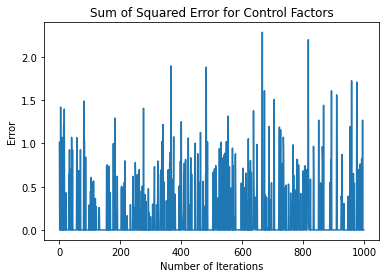

In [53]:
import matplotlib.pyplot as plt

plt.plot(RSS)

plt.xlabel("Number of Iterations")
plt.ylabel("Error")
plt.title("Sum of Squared Error for Control Factors")

max(RSS)
min(RSS)